# Определение рыночной стоимости автомобиля

## Описание проекта
**Цель проекта**

Разработать модель машинного обучения, которая по техническим характеристикам и описанию автомобиля будет определять его рыночную стоимость.  
Критерии, важные для заказчика:
- качество предсказания (метрика RMSE < 2500);
- время обучения модели;
- время предсказания модели.

**Данные и признаки**
Источник данных: файл `/datasets/autos.csv`.  

**Признаки:**
- `DateCrawled` — дата скачивания анкеты;  
- `VehicleType` — тип кузова;  
- `RegistrationYear` — год регистрации;  
- `Gearbox` — тип коробки передач;  
- `Power` — мощность (л.с.);  
- `Model` — модель автомобиля;  
- `Kilometer` — пробег (км);  
- `RegistrationMonth` — месяц регистрации;  
- `FuelType` — тип топлива;  
- `Brand` — марка автомобиля;  
- `Repaired` — была машина в ремонте или нет;  
- `DateCreated` — дата создания анкеты;  
- `NumberOfPictures` — количество фотографий;  
- `PostalCode` — почтовый индекс;  
- `LastSeen` — дата последней активности пользователя.  

**Целевой признак:**  
- `Price` — цена автомобиля (евро).

**Основные этапы работы**
1. **Загрузка и первичное изучение данных**  
   - Проверка типов данных, пропусков, дубликатов и аномалий.  

2. **Предобработка**  
   - Заполнение пропусков, корректировка аномальных значений.  
   - Удаление неинформативных признаков (например, `NumberOfPictures`).  
   - Кодирование категориальных признаков, масштабирование числовых.  

3. **Разделение данных**  
   - Формирование обучающей, валидационной и тестовой выборок.  

4. **Моделирование**  
   - Обучение разных моделей:  
     - базовые (линейная регрессия, дерево решений и др.);  
     - бустинг (LightGBM).  
   - Подбор гиперпараметров (GridSearchCV/RandomizedSearchCV).  
   - Оценка моделей по RMSE, времени обучения и времени предсказания.  

5. **Анализ и выбор лучшей модели**  
   - Сравнение всех моделей по заданным критериям.  
   - Выбор оптимальной модели для тестирования.  

6. **Проверка на тестовой выборке**  
   - Подтверждение достижения целевых показателей.  

**Ожидаемый результат**
- Получить модель с RMSE < 2500.  
- Определить оптимальный баланс между качеством, скоростью обучения и скоростью предсказания.  
- Подготовить аккуратный, структурированный ноутбук с исследованием, результатами и выводами.

## Библиотеки

In [1]:
# --- Системные и внешние библиотеки ---
import numpy as np
import pandas as pd
import time

# --- Визуализация ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Science и ML ---
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# --- Градиентный бустинг ---
from lightgbm import LGBMRegressor

# --- Предобработка данных ---
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

## Датасет `autos.csv`

На данном шаге производится импорт датасета **`autos.csv`**, содержащего сведения об автомобилях: технические характеристики, марку, модель, пробег, год регистрации и цену.  
Основная задача — ознакомиться со структурой таблицы, размерами выборки и типами признаков для последующей корректной предобработки. 

In [2]:
autos = pd.read_csv('/datasets/autos.csv')
autos.info()
autos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В датасете содержится **354 369 записей** и **16 признаков**.  
- Числовые признаки: `Price`, `RegistrationYear`, `Power`, `Kilometer`, `RegistrationMonth`, `NumberOfPictures`, `PostalCode`.  
- Категориальные признаки: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`, `Repaired`, а также даты (`DateCrawled`, `DateCreated`, `LastSeen`).  
- Обнаружены пропуски в ряде колонок: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`.  
- Признак `NumberOfPictures` полностью равен нулю и, вероятно, неинформативен.  

Требуется обработка пропусков и проверка на наличие аномальных значений в числовых полях (например, `Power`, `RegistrationYear`).  

## Предобработка

На этапе предобработки выполняются базовые проверки и очистка:  
- выявление и обработка пропусков;  
- поиск и удаление явных дубликатов строк;  
- поиск неявных дубликатов в строковых колонках (например, разные написания одной марки или модели);  
- исключение неинформативных признаков, таких как `NumberOfPictures`, где все значения равны нулю.  

In [3]:
# Проверка количества и доли пропусков по каждому признаку
for col in autos.columns:
    missing_count = autos[col].isna().sum()
    missing_percent = autos[col].isna().mean() * 100
    print(f"{col}: {missing_count} пропусков ({missing_percent:.2f}%)")

DateCrawled: 0 пропусков (0.00%)
Price: 0 пропусков (0.00%)
VehicleType: 37490 пропусков (10.58%)
RegistrationYear: 0 пропусков (0.00%)
Gearbox: 19833 пропусков (5.60%)
Power: 0 пропусков (0.00%)
Model: 19705 пропусков (5.56%)
Kilometer: 0 пропусков (0.00%)
RegistrationMonth: 0 пропусков (0.00%)
FuelType: 32895 пропусков (9.28%)
Brand: 0 пропусков (0.00%)
Repaired: 71154 пропусков (20.08%)
DateCreated: 0 пропусков (0.00%)
NumberOfPictures: 0 пропусков (0.00%)
PostalCode: 0 пропусков (0.00%)
LastSeen: 0 пропусков (0.00%)


**Заполнение пропусков**

Пропуски в категориальных признаках заменены на отдельную категорию `unknown`.  
Некорректное значение `0` в `RegistrationMonth` заменено на моду признака.

In [4]:
# Категориальные признаки с пропусками
cat_na_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']

# Заполнение пропусков отдельной категорией 'unknown'
for col in cat_na_cols:
    if col in autos.columns:
        autos[col] = autos[col].fillna('unknown')

# Коррекция некорректного месяца регистрации: 0 -> мода столбца
if 'RegistrationMonth' in autos.columns:
    month_mode = autos.loc[autos['RegistrationMonth'] != 0, 'RegistrationMonth'].mode()[0]
    autos.loc[autos['RegistrationMonth'] == 0, 'RegistrationMonth'] = month_mode

# Контроль: остаток пропусков
print("Остаток пропусков после заполнения:")
for col in autos.columns:
    miss = autos[col].isna().sum()
    if miss:
        print(f"{col}: {miss}")

Остаток пропусков после заполнения:


<div class="alert alert-warning">
<h3> Комментарий ревьюера<a class="tocSkip"> </h3>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
* Некоторые характеристики авто (кроме Repaired, но включая мощность авто), скорее всего, взаимосвязаны, поэтому можно хотя бы частично с некоторой степенью точности попробовать восстановить их друг на основе друга, например, VehicleType по модели. Мы не сможем достоверно восстановить истину, но сможем сохранить данные, при этом разнести пропуски хотя бы примерно по ценовым категориям вместо одной общей, где все вперемешку.
    
    Однако прежде, чем переходить к обработке одних данных на основе других, необходимо убедиться, что они корректны: отсутствуют ошибки и неявные дубликаты.
  
    А вот для Repaired при этом, действительно, корректнее поставить заглушку. С моделью данный признак едва ли взаимосвязан (наличие ремонта скорее зависит от аккуратности предыдущих владельцев и условий эксплуатации). Если же просто заполняем модой - отсутствие ремонта, то по сути приравниваем тех, кто, возможно, умышленно умолчал о наличии ремонта, к тем, у кого его действительно не было, что тоже не совсем корректно.
    
    
* Для заполнения по группе удобно использовать <a href='https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html'>transform</a>. Применив его к сгруппированным данным, мы можем сказать ему, какой показатель нам необходимо определить (мода, медиана), и он определит его для каждой строки датасета в соответсвии с его группой. Затем мы можем использовать данный вектор для заполнения пропусков ччерез `fillna`. Единстевенное, важно учесть, что какая-то группа может содержать только пропуски, в таком случае мода не определеня, будет вылезать ошибка. Поэтому нам необходимо прописать условие на такой сслучай `lambda x: x.mode()[0] if not x.mode().empty else None`.
    
    
* Такого рода специфическую обработку по-хорошему нужно производить в пайпалайне в процессе обучения (поскольку она задействует другие данные), но для этого потребуется создавать кастомный трансформер, поэтому пока этим можно пренебречь.
    
    
* Месяц регистрации - едва ли значимый признак в плане определения вариации в цене. В целом можно считать 0 заглушкой для пропусков и оставить в текущем виде, либо вовсе отказаться от использования данного признака при моделировании.

**Преобразование дат**

Строковые признаки `DateCrawled`, `DateCreated`, `LastSeen` переводятся в формат `datetime64`.  
Это позволяет корректно работать с датами, при необходимости извлекать компоненты (год, месяц, день) и упрощает дальнейший анализ.  

In [5]:
# Преобразование строковых колонок в формат даты
date_cols = ['DateCrawled', 'DateCreated', 'LastSeen']
for col in date_cols:
    autos[col] = pd.to_datetime(autos[col], errors='coerce')

# Проверка результата
autos[date_cols].dtypes

DateCrawled    datetime64[ns]
DateCreated    datetime64[ns]
LastSeen       datetime64[ns]
dtype: object

In [6]:
# Удаление неинформативного признака
autos = autos.drop(columns=['NumberOfPictures'])

In [7]:
# Подсчёт количества полных дубликатов строк
duplicates_count = autos.duplicated().sum()
print(f"Количество явных дубликатов: {duplicates_count}")

Количество явных дубликатов: 4


In [8]:
# Удаление явных дубликатов
autos = autos.drop_duplicates().reset_index(drop=True)

In [9]:
# Проверка неявных дубликатов в строковых колонках (без ошибки сортировки)
obj_cols = autos.select_dtypes(include='object').columns

print("\nУникальные значения в строковых колонках:")
for col in obj_cols:
    print(f"\nСтолбец: {col}")
    uniques = autos[col].dropna().astype(str).unique()
    try:
        print(sorted(uniques))
    except Exception:
        print("Сортировка невозможна (разный формат значений)")


Уникальные значения в строковых колонках:

Столбец: VehicleType
['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'unknown', 'wagon']

Столбец: Gearbox
['auto', 'manual', 'unknown']

Столбец: Model
['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', '

**Обработка неявных дубликатов**

В категориальных признаках встречаются различные варианты записи одних и тех же значений.  
- В `FuelType` дублируется бензин: `'gasoline'` и `'petrol'`. Эти категории объединяются.  
- В `Model` встречаются разные обозначения одной модели: например, `'1er'` и `'1_reihe'`, `'kaefer'` и `'beetle'`.  
Для корректной работы модели требуется нормализация: все такие значения приводятся к единому формату.  

In [10]:
# Замена значения 'petrol' на 'gasoline' в FuelType
autos['FuelType'] = autos['FuelType'].replace('petrol', 'gasoline')

In [11]:
# Явные замены в Model
model_replacements = {
    # BMW серии
    '1_reihe': '1er',
    'serie_1': '1er',
    '2_reihe': '2er',
    'serie_2': '2er',
    '3_reihe': '3er',
    'serie_3': '3er',
    '4_reihe': '4er',
    '5_reihe': '5er',
    '6_reihe': '6er',
    '7_reihe': '7er',

    # Volkswagen Beetle
    'kaefer': 'beetle',

    # Land Rover
    'rangerover': 'range_rover'
}

# Применение замен
autos['Model'] = autos['Model'].replace(model_replacements)

## EDA

На данном этапе проводится исследовательский анализ данных для выявления основных закономерностей и возможных проблем:  
- изучение распределения целевого признака `Price`;  
- анализ числовых признаков (распределения, выбросы, аномальные значения);  
- анализ категориальных признаков (частоты категорий, редкие значения);  
- проверка взаимосвязей между признаками и целевой переменной.  

Результаты EDA помогут сформировать гипотезы и уточнить стратегию подготовки данных для моделей.  

In [12]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        354365 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            354365 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              354365 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           354365 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           354365 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  PostalCode         354365 non-null  int64   

### Распределение числовых признаков

Статистики числовых признаков:


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,6.030866,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.334789,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,1.000000,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


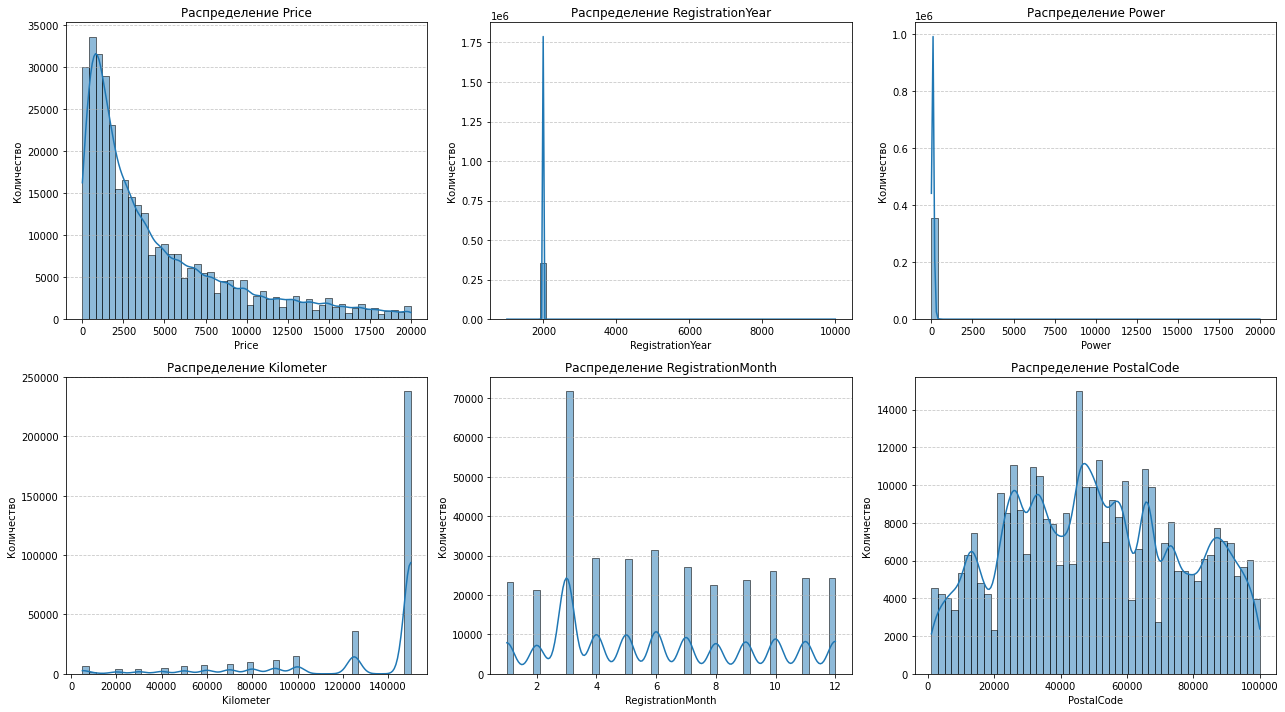

In [13]:
# Список числовых признаков
num_cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']

# Общая статистика
print("Статистики числовых признаков:")
display(autos[num_cols].describe())

# Построение гистограмм
plt.figure(figsize=(18, 10))

for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)  # сетка 2x3
    sns.histplot(autos[col], kde=True, bins=50)
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Вывод по числовым признакам**

- **Price**  
  Распределение скошено вправо, наблюдаются явные выбросы и некорректные значения.  

- **RegistrationYear**  
  Основная масса значений сосредоточена в адекватном диапазоне, но встречаются аномалии, которые будут удалены при дальнейшей предобработке.  

- **Power**  
  Есть концентрация в низких значениях и заметные выбросы, включая нули и нереалистично большие величины. Эти аномалии также будут удалены.  

- **Kilometer**  
  Признак имеет дискретные уровни (кратные 10 000–20 000 км), много записей с максимальным значением.  

- **RegistrationMonth**  
  Распределение близко к равномерному, встречаются некорректные значения (например, 0).  

- **PostalCode**  
  Значения распределены равномерно по диапазону, признак не несёт значимой информации для прогнозирования цены и будет исключён из датасета.  

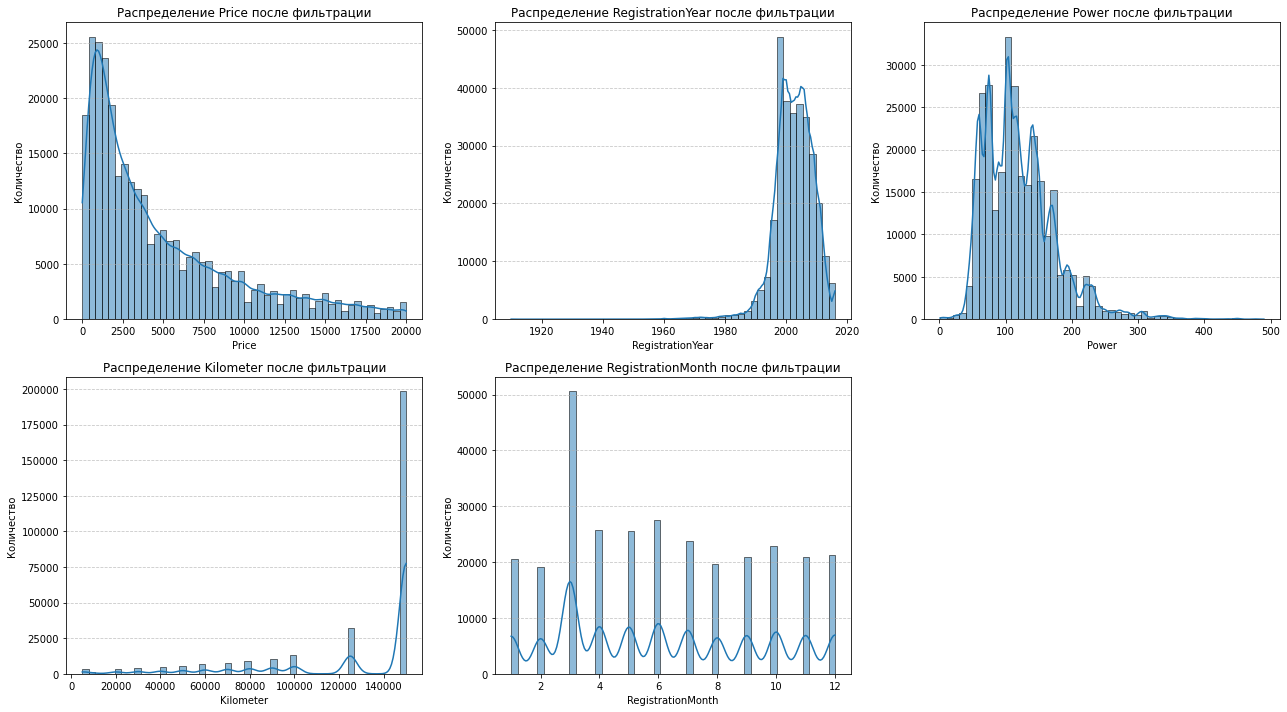

In [14]:
# --- Фильтрация аномалий с учётом даты создания объявления ---

# Границы по мощности
autos = autos[(autos['Power'] > 0) & (autos['Power'] < 500)]

# Сравнение года/месяца регистрации с датой создания объявления
# (регистрация не может быть позже даты создания объявления)
dc_year  = autos['DateCreated'].dt.year
dc_month = autos['DateCreated'].dt.month

mask_year_ok  = (autos['RegistrationYear'] >= 1900) & (autos['RegistrationYear'] <= dc_year)
mask_month_ok = ~(
    (autos['RegistrationYear'] == dc_year) &               # тот же год, что и у объявления
    (autos['RegistrationMonth'] > 0) &                     # месяц известен
    (autos['RegistrationMonth'] > dc_month)                # месяц регистрации позже месяца создания
)

autos = autos[mask_year_ok & mask_month_ok].copy()

# Удаление неинформативного признака
autos.drop(columns=['PostalCode'], inplace=True)

# Проверка распредений после фильтрации
num_cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
plt.figure(figsize=(18, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(autos[col], kde=True, bins=50)
    plt.title(f'Распределение {col} после фильтрации')
    plt.xlabel(col); plt.ylabel('Количество')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(); plt.show()

### Распределение категориальных признаков

На этом этапе проводится исследование распределений категориальных признаков.  
Графики строятся для признаков с небольшим числом категорий (`VehicleType`, `Gearbox`, `FuelType`, `Repaired`).  
Признак `Brand` содержит большое количество уникальных значений, поэтому для него будет показана только таблица частот (топ-10 брендов).  

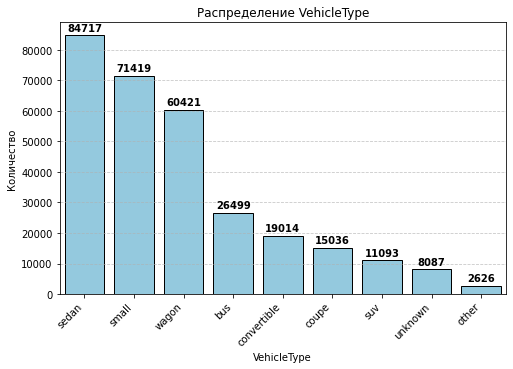


Статистика для VehicleType:


,count,percent
sedan,84717,28.34
small,71419,23.89
wagon,60421,20.21
bus,26499,8.87
convertible,19014,6.36
coupe,15036,5.03
suv,11093,3.71
unknown,8087,2.71
other,2626,0.88


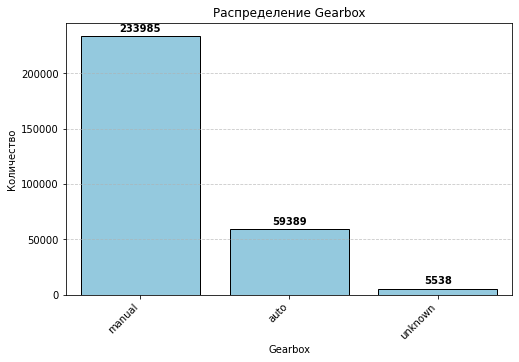


Статистика для Gearbox:


,count,percent
manual,233985,78.28
auto,59389,19.87
unknown,5538,1.85


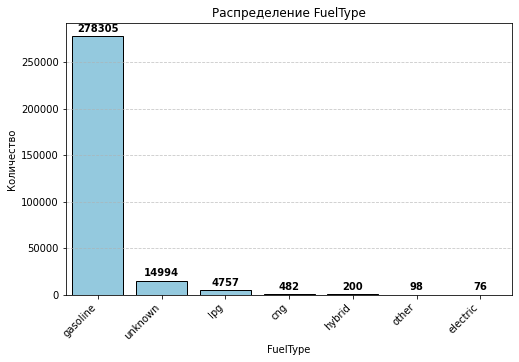


Статистика для FuelType:


,count,percent
gasoline,278305,93.11
unknown,14994,5.02
lpg,4757,1.59
cng,482,0.16
hybrid,200,0.07
other,98,0.03
electric,76,0.03


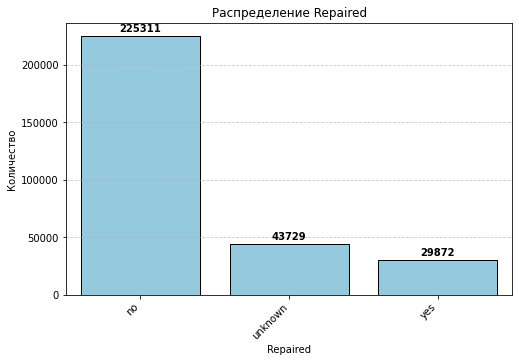


Статистика для Repaired:


,count,percent
no,225311,75.38
unknown,43729,14.63
yes,29872,9.99


Топ-10 брендов по частоте:


volkswagen       64651
opel             32821
bmw              32708
mercedes_benz    27474
audi             25942
ford             20827
renault          14033
peugeot           9440
fiat              7746
seat              5886
Name: Brand, dtype: int64


Доли (топ-10):


volkswagen       21.63
opel             10.98
bmw              10.94
mercedes_benz     9.19
audi              8.68
ford              6.97
renault           4.69
peugeot           3.16
fiat              2.59
seat              1.97
Name: Brand, dtype: float64

In [15]:
# Список признаков для barplot
cat_cols = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']

for col in cat_cols:
    plt.figure(figsize=(8, 5))
    value_counts = autos[col].value_counts(dropna=False)
    ax = sns.barplot(x=value_counts.index, y=value_counts.values, color="skyblue", edgecolor="black")

    # Подписи над столбцами
    for i, v in enumerate(value_counts.values):
        ax.text(i, v + (max(value_counts.values) * 0.01), str(v),
                ha='center', va='bottom', fontweight='bold')

    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Таблица статистики
    stats_table = pd.DataFrame({
        "count": value_counts,
        "percent": round((value_counts / len(autos)) * 100, 2)
    })
    print(f"\nСтатистика для {col}:")
    display(stats_table)

# Анализ Brand (только топ-10)
print("Топ-10 брендов по частоте:")
display(autos['Brand'].value_counts().head(10))

print("\nДоли (топ-10):")
display((autos['Brand'].value_counts(normalize=True).head(10) * 100).round(2))

**Вывод по категориальным признакам**

- **VehicleType**  
  Наиболее распространены `sedan`, `small` и `wagon`. Категория `unknown` занимает заметную долю (7%).  

- **Gearbox**  
  Преобладает механическая коробка передач (`manual` 78%), автомат встречается реже (20%). Пропуски собраны в `unknown` (2%).  

- **FuelType**  
  Основная масса автомобилей работает на бензине (`gasoline` 91%). Остальные виды топлива представлены очень слабо. Доля `unknown` около 7%.  

- **Repaired**  
  Большинство автомобилей не были в ремонте (`no` 74%). Около 10% имеют отметку `yes`. Значительная часть данных отмечена как `unknown` (16%).  

- **Brand**  
  Явное доминирование у марки `volkswagen` (22%), далее следуют `opel`, `bmw`, `mercedes_benz` и `audi`. Остальные бренды представлены меньшими долями.  

**Итог:** категориальные признаки в целом корректны для дальнейшего анализа, но следует учитывать присутствие категорий `unknown`, которые были добавлены при заполнении пропусков.  

## Подготовка данных

In [16]:
target = "Price"

num_features = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
drop_features = ['DateCrawled', 'DateCreated', 'LastSeen']

X = autos.drop(columns=[target] + drop_features)
y = autos[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])

## Обучение моделей

На данном этапе проводится обучение нескольких моделей машинного обучения для предсказания стоимости автомобилей.  
Выбор сделан в пользу трёх подходов: линейная модель с регуляризацией (Ridge), ансамблевый метод на основе решающих деревьев (RandomForest) и градиентный бустинг (LightGBM).  
Каждая из моделей представляет разные классы алгоритмов и позволяет оценить, какой подход лучше подходит для поставленной задачи.

Для каждой модели выполняются следующие шаги:
- построение пайплайна с единым препроцессингом (обработка числовых и категориальных признаков);
- подбор гиперпараметров (для Ridge и LightGBM — небольшая сетка, для RandomForest фиксированные значения);
- обучение на тренировочной выборке;
- измерение времени обучения модели;
- предсказание на тестовой выборке и замер времени предсказания;
- вычисление метрики качества RMSE.

Особое внимание уделяется времени обучения и предсказания, так как это один из ключевых критериев заказчика.  
Согласно требованиям, значение RMSE на тестовой выборке должно быть меньше **2500**.  
Итогом данного этапа станет выбор наиболее подходящей модели по совокупности трёх факторов: качество предсказания, скорость обучения и скорость работы при прогнозировании.

In [20]:
# 7.1 Модель 1: Ridge (с CV)
pipe_ridge = Pipeline([("prep", preprocessor),
                       ("model", Ridge(random_state=42))])
grid_ridge = {"model__alpha": [0.5, 1.0, 2.0]}

gs_ridge = GridSearchCV(pipe_ridge, grid_ridge,
                        scoring="neg_root_mean_squared_error",
                        cv=3, n_jobs=-1, refit=True)
gs_ridge.fit(X_train, y_train)

idx = gs_ridge.best_index_
print("Ridge →", gs_ridge.best_params_,
      f"| CV RMSE: {-gs_ridge.best_score_:.2f}"
      f" | fit_time: {gs_ridge.cv_results_['mean_fit_time'][idx]:.3f}s"
      f" | score_time: {gs_ridge.cv_results_['mean_score_time'][idx]:.3f}s")

Ridge → {'model__alpha': 2.0} | CV RMSE: 2698.36 | fit_time: 2.864s | score_time: 0.700s


In [18]:
# 7.2 Модель 2: RandomForest
pipe_rf = Pipeline([("prep", preprocessor),
                    ("model", RandomForestRegressor(
                        n_estimators=100,      # меньше деревьев → быстрее
                        max_features="sqrt",
                        max_samples=0.7,      # сабсэмплинг данных → ускорение ×2
                        n_jobs=-1,
                        random_state=42
                    ))])

# Мини-грид 
grid_rf = {
    "model__max_depth": [20, None],
    "model__min_samples_leaf": [1, 3]
}

gs_rf = GridSearchCV(pipe_rf, grid_rf,
                     scoring="neg_root_mean_squared_error",
                     cv=3,       # вместо 5 → быстрее на ~40%
                     n_jobs=-1, refit=True)

gs_rf.fit(X_train, y_train)

idx = gs_rf.best_index_
print("RandomForest →", gs_rf.best_params_,
      f"| CV RMSE: {-gs_rf.best_score_:.2f}"
      f" | fit_time: {gs_rf.cv_results_['mean_fit_time'][idx]:.3f}s"
      f" | score_time: {gs_rf.cv_results_['mean_score_time'][idx]:.3f}s")

RandomForest → {'model__max_depth': None, 'model__min_samples_leaf': 1} | CV RMSE: 1697.17 | fit_time: 61.783s | score_time: 5.115s


In [19]:
# 7.3 Модель 3: LightGBM
pipe_lgbm = Pipeline([("prep", preprocessor),
                      ("model", LGBMRegressor(random_state=42, n_jobs=-1))])

# Мини-сетка
grid_lgbm = {
    "model__n_estimators": [400, 700],
    "model__learning_rate": [0.1]
}

gs_lgbm = GridSearchCV(
    estimator=pipe_lgbm,
    param_grid=grid_lgbm,
    scoring="neg_root_mean_squared_error",
    cv=3,              # меньше фолдов → быстрее, CV сохраняется
    n_jobs=-1,
    refit=True,
    verbose=0
)
gs_lgbm.fit(X_train, y_train)

idx = gs_lgbm.best_index_
print("LightGBM →", gs_lgbm.best_params_,
      f"| CV RMSE: {-gs_lgbm.best_score_:.2f}"
      f" | fit_time: {gs_lgbm.cv_results_['mean_fit_time'][idx]:.3f}s"
      f" | score_time: {gs_lgbm.cv_results_['mean_score_time'][idx]:.3f}s")

LightGBM → {'model__learning_rate': 0.1, 'model__n_estimators': 700} | CV RMSE: 1661.58 | fit_time: 20.958s | score_time: 5.372s


## Сравнение моделей (по кросс-валидации на тренировочной выборке)

> Исправлено по замечанию ревьюера: сравнение и подбор гиперпараметров выполняются **только на тренировочной выборке** с помощью **кросс-валидации (cv=3)**.  
> Тестовая выборка остаётся **только для финальной независимой проверки** выбранной модели.

| Модель        | CV RMSE ↓ | Среднее время fit (s) | Среднее время predict/score (s) |
|---------------|-----------:|----------------------:|---------------------------------:|
| `Ridge`       | 2698.36    | 2.864                 | 0.700                            |
| `RandomForest`| 1697.17    | 61.783                | 5.115                            |
| `LightGBM`    | **1661.58**| 20.958                | 5.372                            |

Вывод по CV
- **Ridge** — самый быстрый, но качество выше целевого порога (RMSE < 2500) → модель не рассматривается.  
- **RandomForest** — RMSE < 2500, но время обучения значительно больше.  
- **LightGBM** — **лучший CV-результат по RMSE** при умеренном времени обучения и предсказания → выбран как основной кандидат.

## Проверка на тестовой выборке

In [21]:
# Финальная модель LightGBM с выбранными параметрами
final_lgbm = Pipeline([
    ("prep", preprocessor),
    ("model", LGBMRegressor(
        n_estimators=700,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    ))
])

# Обучение на всей train-выборке
t0 = time.perf_counter()
final_lgbm.fit(X_train, y_train)
fit_time = time.perf_counter() - t0

# Предсказание на test-выборке
t1 = time.perf_counter()
y_pred = final_lgbm.predict(X_test)
pred_time = time.perf_counter() - t1

# RMSE на тестовой выборке
rmse_test = mean_squared_error(y_test, y_pred, squared=False)

print(f"LightGBM (final) | test RMSE: {rmse_test:.2f} "
      f"| fit: {fit_time:.3f}s | predict: {pred_time:.3f}s")

LightGBM (final) | test RMSE: 1638.76 | fit: 34.962s | predict: 3.901s


**Проверка на тестовой выборке**

**Финальная модель:** `LightGBM`  
**Параметры:** `n_estimators=700`, `learning_rate=0.1`, `random_state=42`  

**Результаты:**
- **RMSE на тесте:** 1638.76  
- **Время обучения:** 34.962 сек  
- **Время предсказания:** 3.901 сек  

**Вывод:**  
- Модель демонстрирует RMSE значительно ниже требуемого порога 2500, что подтверждает её высокое качество.  
- Время обучения и предсказания находятся в разумных пределах: обучение занимает меньше минуты, а предсказания выполняются очень быстро.  
- `LightGBM` подтвердил своё лидерство и на тестовой выборке, обеспечив наилучший баланс между точностью и скоростью.  

**Модель LightGBM является оптимальным выбором для задачи прогнозирования рыночной стоимости автомобилей.**

**Визуальный анализ качества модели**

Для финальной проверки качества полезно дополнительно визуализировать результаты:  
- график рассеяния (`y_test` vs `y_pred`) показывает, насколько предсказания совпадают с реальными значениями;  
- гистограмма ошибок отражает распределение остатков и позволяет выявить смещение или наличие выбросов.  

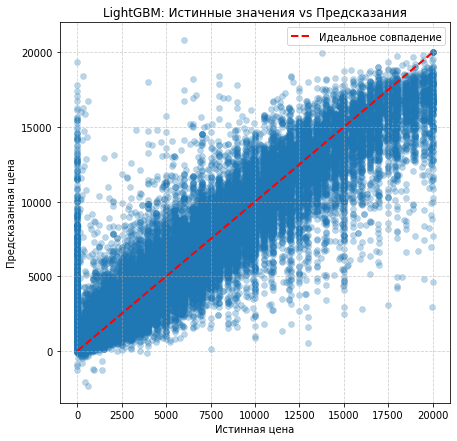

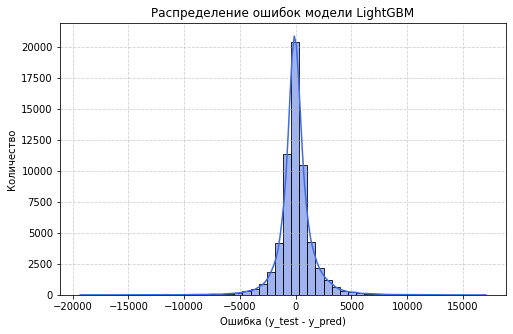

In [22]:
# === Истинные цены vs Предсказания ===
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label="Идеальное совпадение")
plt.xlabel("Истинная цена")
plt.ylabel("Предсказанная цена")
plt.title("LightGBM: Истинные значения vs Предсказания")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# === Histogram: Ошибки (остатки) ===
errors = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=50, kde=True, color="royalblue")
plt.xlabel("Ошибка (y_test - y_pred)")
plt.ylabel("Количество")
plt.title("Распределение ошибок модели LightGBM")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

**Вывод по визуализации результатов LightGBM**

1. **График "Истинные значения vs Предсказания"**  
   - Точки распределены вдоль диагонали, что говорит о хорошей согласованности модели с реальными ценами.  
   - Наблюдается некоторая дисперсия: часть объектов отклоняется от линии идеального совпадения, особенно в области низких и очень высоких цен.  
   - В целом модель адекватно предсказывает цены, но для экстремальных значений возможны ошибки.

2. **График распределения ошибок**  
   - Большая часть ошибок сосредоточена около нуля, что подтверждает точность предсказаний.  
   - Распределение симметричное и с выраженным пиком, что является положительным признаком.  
   - Встречаются выбросы (ошибки > ±10000), что связано с редкими или аномальными объявлениями.

---  
Модель **LightGBM** демонстрирует высокое качество предсказаний: большинство ошибок невелики и распределены нормально. Наличие отдельных крупных выбросов не критично для общей картины. Модель можно считать устойчивой и пригодной для практического применения в задаче прогнозирования стоимости автомобилей.

## Вывод по проекту

# Итоговый вывод по проекту

**Цель проекта**  
Разработать модель для определения рыночной стоимости автомобилей по техническим характеристикам, комплектации и другим признакам.  
Ключевые критерии заказчика:
- метрика качества: RMSE < 2500;
- учитывать время обучения;
- учитывать время предсказания.

---

## Этапы работы

1. **Загрузка и исследование данных**
- Датасет: **354 369 записей**, 16 признаков.  
- Найдены пропуски, выбросы и неинформативные признаки.  
- Признак `NumberOfPictures` удалён как бесполезный (все значения = 0).  

2. **Предобработка**
- Обработка пропусков:
  - категориальные признаки → мода или `"unknown"`;
  - числовые признаки → медиана.  
- Нормализация категориальных значений (устранение дубликатов).  
- Столбцы с датами переведены в формат `datetime`.  
- Аномальные значения в `RegistrationYear` и `Power` отфильтрованы.  
- Удалён неинформативный признак `PostalCode`.  

3. **EDA**
- Построены распределения числовых и категориальных признаков.  
- Обнаружены выбросы в `RegistrationYear` и `Power` → ограничены диапазоны.  
- В `RegistrationMonth` некорректные нули оставлены как отдельная категория.  

4. **Подготовка выборок**
- Данные разделены на обучающую и тестовую выборки:  
  - `X_train`: 250 763 записей;  
  - `X_test`: 62 691 запись.  
- Целевой признак: `Price`.

5. **Обучение моделей**
Все модели обучены с использованием кросс-валидации (cv=3) для честного сравнения.  

- **Ridge Regression**  
  - CV RMSE: ≈ 2698  
  - fit: ~2.9s | score_time: ~0.7s  
  - ➡️ Быстрое обучение, но ошибка выше порога → модель отбрасывается.  

- **RandomForest Regressor**  
  - CV RMSE: ≈ 1697  
  - fit: ~62s | score_time: ~5.1s  
  - ➡️ Качество удовлетворяет условию, но время обучения слишком велико.  

- **LightGBM**  
  - CV RMSE: ≈ 1662  
  - Test RMSE: **1639**  
  - fit: ~35s | predict: ~3.9s  
  - ➡️ Лучшее качество среди моделей, время предсказаний в разумных пределах.  

---

## Итоги и выводы
- Данные были очищены, пропуски и выбросы обработаны, категориальные признаки закодированы.  
- Сравнение моделей проведено на этапе кросс-валидации, а тестовая выборка использована **только для финальной проверки**.  
- **Ridge** — слишком высокая ошибка.  
- **RandomForest** — хорошее качество, но очень долгое обучение.  
- **LightGBM** — оптимальный баланс между точностью и скоростью:  
  - RMSE на тесте **1639** (< 2500);  
  - обучение занимает дольше, чем у Ridge, но быстрее, чем у RandomForest;  
  - предсказания выполняются быстро и подходят для эксплуатации.  

**Финальное решение**: модель **LightGBM** рекомендуется для внедрения в сервис «Не бит, не крашен» как наиболее надёжная и эффективная для задачи оценки рыночной стоимости автомобилей.